# Recurrent Neural Networks for Predictive Maintenance 

## Predict failure and RUL (remaining usefull lifetime) of NASA Aircraft Machines

Author: Tatjana Chernenko, March 2024

![Aicraft_Machines](engine-airplane-free-image-2048x1365.jpg)

## Scenario

One data source (sensor values) is used to make predictions.

### Goals: 
- Binary classification: Predict if an asset will fail within certain time frame (e.g. days).
- Regression: Predict the Remaining Useful Life (RUL), or Time to Failure (TTF).
- Multi-class classification: Predict if an asset will fail in different time windows: E.g., fails in window [1, w0] days; fails in the window [w0+1,w1] days; not fail within w1 days

### Solution:
- LSTM

### Data:
Dataset: Azure blob dataset with simulated aircraft engine run-to-failure events.
It is already divided into train, test and ground truth data.

- Training data: It is the aircraft engine run-to-failure data.
- Testing data: It is the aircraft engine operating data without failure events recorded.
- Ground truth data: It contains the information of true remaining cycles for each engine in the testing data.

![Data_Schema](dataSchema1.jpeg)

#### Training Data

Consists of multiple multivariate time series with *"cycle"* as the time unit, together with *21 sensor readings for each cycle*.

Each time series can be assumed as being generated from a *different engine* of the same type. 

Each engine is assumed to start with different degrees of initial wear and manufacturing variation, and this information is unknown to the user. In this simulated data, the engine is assumed to be operating normally at the start of each time series. It starts to degrade at some point during the series of the operating cycles. The degradation progresses and grows in magnitude. When a predefined threshold is reached, then the engine is considered unsafe for further operation. 

In other words, *the last cycle in each time series can be considered as the failure point of the corresponding engine*. 

#### Test Data

The testing data has the same data schema as the training data. The only difference is that the data *does not indicate when the failure occurs* (in other words, **the last time period does NOT represent the failure point**). 
It is not shown how many more cycles this engine can last before it fails.


#### Ground Truth Data


The ground truth data provides the number of remaining working cycles for the engines in the testing data. 

![SampleData](sampleData.jpeg)

#### Imports

In [63]:
# imports

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wget
import pandas as pd

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation

%matplotlib inline

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

#### Load Data

In [8]:

# Data ingestion - reading the datasets from Azure blob:

!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt 

--2024-03-31 15:12:21--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.213.67, 13.107.246.67
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.213.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: 'PM_train.txt'

PM_train.txt        100%[===================>]   3.35M  1.97MB/s    in 1.7s    

2024-03-31 15:12:23 (1.97 MB/s) - 'PM_train.txt' saved [3515356/3515356]

--2024-03-31 15:12:23--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.213.67, 13.107.246.67
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.213.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: 'PM_test.txt'

PM_test.txt         100%[===================>]   2.12M  1

## Understand Data

In [12]:
# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


- Columns 26 and 27 in train, test and ground truth data have no information (NaN). We drop them.
- The columns are not named properly; we use dataset specification to identify the proper names and rename them.

In [15]:
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [16]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


- Columns 26 and 27 in train, test and ground truth data have no information (NaN). We drop them.
- The columns are not named properly; we use dataset specification to identify the proper names and rename them.

In [17]:
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [20]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [21]:
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


In [23]:
# Sort train data:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Preparation

#### Generate Labels (dataset specification requires this to be done based on the metadata)

According to the specification in https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2, the training data must be labeled, where "RUL", label1", and "label2" are labels for regression, binary classification, and multi-class classification models respectively. Here w0 and w1 are predefined use case related parameters which are used to label the training data. 

![Labels](labeling_1.jpeg)

#### RUL labels (remaining usefull life)

In [24]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


#### Generate labels 1 and 2

- Label 1: for binary clasification, while trying to answer the question: is a specific engine going to fail within w1 cycles?
- Label 2: for multiclass classification, not needed for the current approach (though we still generate it for future needs).

In [27]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


## Data Understanding, EDA

#### Train Data:

In [29]:
# Summary statistics
print("\nSummary Statistics for Training Data:")
print(train_df.describe())


Summary Statistics for Training Data:
                 id         cycle      setting1      setting2  setting3  \
count  20631.000000  20631.000000  20631.000000  20631.000000   20631.0   
mean      51.506568    108.807862     -0.000009      0.000002     100.0   
std       29.227633     68.880990      0.002187      0.000293       0.0   
min        1.000000      1.000000     -0.008700     -0.000600     100.0   
25%       26.000000     52.000000     -0.001500     -0.000200     100.0   
50%       52.000000    104.000000      0.000000      0.000000     100.0   
75%       77.000000    156.000000      0.001500      0.000300     100.0   
max      100.000000    362.000000      0.008700      0.000600     100.0   

                 s1            s2            s3            s4            s5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150 

**Interpretation**

- Count: The dataset contains 20,631 records.

- ID: The IDs range from 1 to 100, indicating the different engines in the dataset.

- Cycle: The cycles range from 1 to 362, with an average of approximately 108.81 cycles and a standard deviation of approximately 68.88 cycles.

- Settings (setting1, setting2, setting3): These settings are numerical variables. setting1 and setting2 have mean values close to zero, with setting1 ranging from -0.0087 to 0.0087 and setting2 ranging from -0.0006 to 0.0006. setting3 has a constant value of 100.

- Sensor Readings (s1 to s21): These sensor readings are numerical variables. They have varying means, standard deviations, minimum, and maximum values. For example, s1 has a mean of approximately 518.67 and ranges from 518.67 to 518.67, indicating that it has a constant value. s2 has a mean of approximately 642.68 and ranges from 641.21 to 644.53.

- Remaining Useful Life (RUL): The RUL ranges from 0 to 361, with an average of approximately 107.81 cycles and a standard deviation of approximately 68.88 cycles.

- Labels (label1, label2): These are binary and multi-class labels. label1 ranges from 0 to 1, indicating binary classification, and label2 ranges from 0 to 2, indicating multi-class classification.

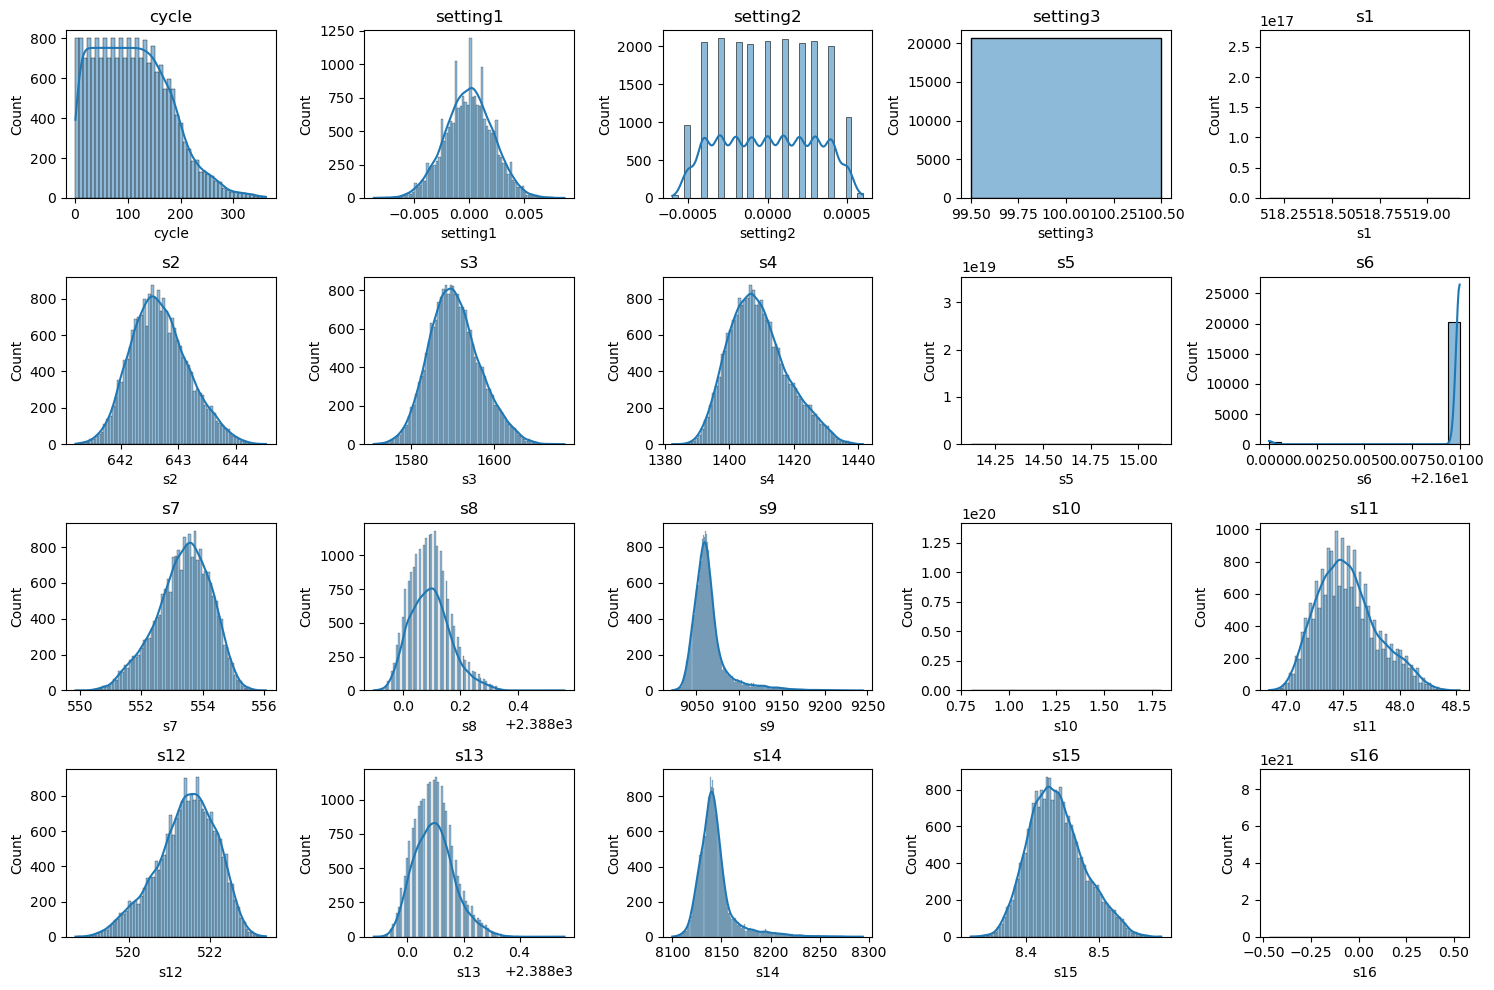

In [45]:
import warnings

warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning)

# Drop non-numeric columns for visualization
train_numeric = train_df.drop(columns=['id'])

# Convert infinite values to NaN
train_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

# Plot histograms for the first 20 columns
num_cols_to_plot = min(20, len(train_numeric.columns))
num_rows = (num_cols_to_plot - 1) // 5 + 1  # Adjust the number of rows based on the number of columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(train_numeric.columns[:num_cols_to_plot]):
    plt.subplot(num_rows, 5, i + 1)
    sns.histplot(train_numeric[col].dropna(), kde=True)  # Drop NaN values before plotting
    plt.title(col)
plt.tight_layout()
plt.show()


In [46]:
# Summary statistics
print("\nSummary Statistics for Test Data:")
print(test_df.describe())


Summary Statistics for Test Data:
                 id         cycle      setting1      setting2  setting3  \
count  13096.000000  13096.000000  13096.000000  13096.000000   13096.0   
mean      51.543907     76.836515     -0.000011      0.000004     100.0   
std       28.289423     53.057749      0.002203      0.000294       0.0   
min        1.000000      1.000000     -0.008200     -0.000600     100.0   
25%       28.000000     33.000000     -0.001500     -0.000200     100.0   
50%       52.000000     69.000000     -0.000000     -0.000000     100.0   
75%       76.000000    113.000000      0.001500      0.000300     100.0   
max      100.000000    303.000000      0.007800      0.000700     100.0   

                 s1            s2            s3            s4            s5  \
count  1.309600e+04  13096.000000  13096.000000  13096.000000  1.309600e+04   
mean   5.186700e+02    642.475088   1588.099204   1404.735362  1.462000e+01   
std    6.014263e-11      0.400899      5.003274     

**Interpretation:**
    
- Count: The dataset contains 13,096 records.
- ID: Similar to the training data, the IDs range from 1 to 100, indicating different engines in the dataset.
- Cycle: The cycles range from 1 to 303, with an average of approximately 76.84 cycles and a standard deviation of approximately 53.06 cycles.
- Settings (setting1, setting2, setting3): These settings are numerical variables. setting1 and setting2 have mean values close to zero, with setting1 ranging from -0.0082 to 0.0078 and setting2 ranging from -0.0006 to 0.0007. setting3 has a constant value of 100.
- Sensor Readings (s1 to s21): These sensor readings are numerical variables. Similar to the training data, they have varying means, standard deviations, minimum, and maximum values.
- Remaining Useful Life (RUL): Not provided in the test data summary statistics, as it is part of the ground truth data and is used for evaluation purposes.
- Labels (label1, label2): Not provided in the test data summary statistics, as they are part of the ground truth data and are used for evaluation purposes.

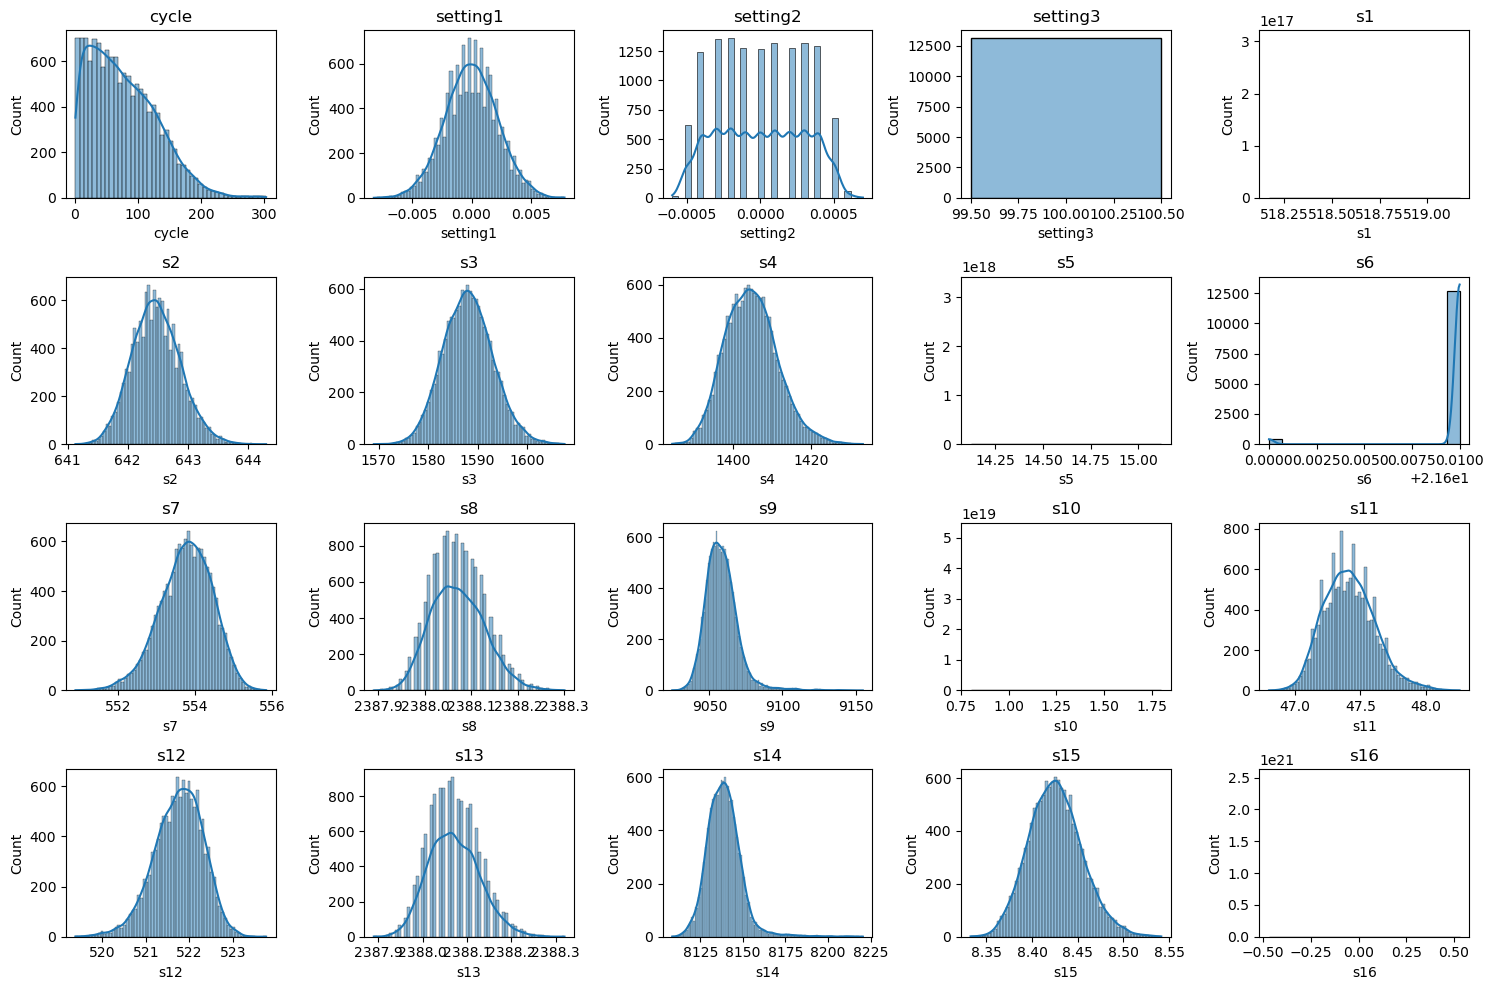

In [47]:

# Drop non-numeric columns for visualization
test_numeric = test_df.drop(columns=['id'])

# Convert infinite values to NaN
test_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

# Plot histograms for the first 20 columns
num_cols_to_plot = min(20, len(test_numeric.columns))
num_rows = (num_cols_to_plot - 1) // 5 + 1  # Adjust the number of rows based on the number of columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(test_numeric.columns[:num_cols_to_plot]):
    plt.subplot(num_rows, 5, i + 1)
    sns.histplot(test_numeric[col].dropna(), kde=True)  # Drop NaN values before plotting
    plt.title(col)
plt.tight_layout()
plt.show()


In [48]:
# Summary statistics
print("\nSummary Statistics for Ground Truth Data:")
print(truth_df.describe())


Summary Statistics for Ground Truth Data:
               0
count  100.00000
mean    75.52000
std     41.76497
min      7.00000
25%     32.75000
50%     86.00000
75%    112.25000
max    145.00000


**Interpretation**
- Count: The dataset contains 100 records.
- Remaining Useful Life (RUL): The RUL values range from 7 to 145, with an average RUL of approximately 75.52 cycles and a standard deviation of approximately 41.76 cycles.
- Minimum RUL: The minimum RUL value is 7 cycles.
- 25th Percentile: 25% of the engines have a RUL of 32.75 cycles or less.
- Median (50th Percentile): 50% of the engines have a RUL of 86 cycles or less.
- 75th Percentile: 75% of the engines have a RUL of 112.25 cycles or less.
- Maximum RUL: The maximum RUL value is 145 cycles.


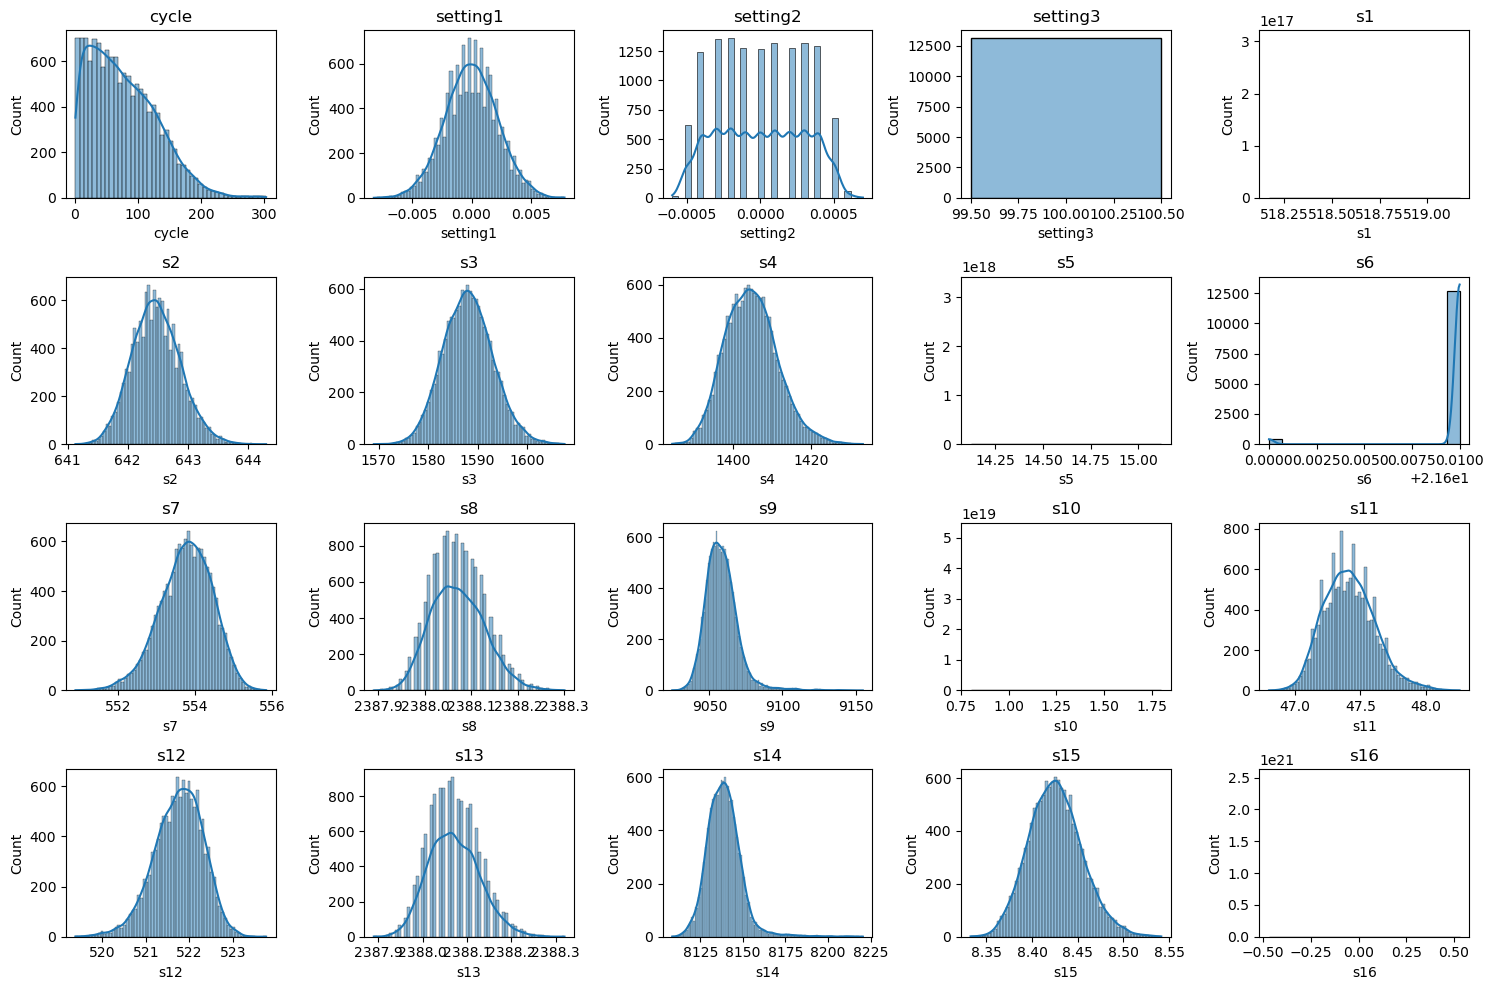

In [50]:
# Drop non-numeric columns for visualization
truth_numeric = test_df.drop(columns=['id'])

# Convert infinite values to NaN
truth_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

# Plot histograms for the first 20 columns
num_cols_to_plot = min(20, len(truth_numeric.columns))
num_rows = (num_cols_to_plot - 1) // 5 + 1  # Adjust the number of rows based on the number of columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(truth_numeric.columns[:num_cols_to_plot]):
    plt.subplot(num_rows, 5, i + 1)
    sns.histplot(truth_numeric[col].dropna(), kde=True)  # Drop NaN values before plotting
    plt.title(col)
plt.tight_layout()
plt.show()

In [53]:
# Check for missing values
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())
# Check for missing values
print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())
# Check for missing values
print("\nMissing Values in Ground Truth Data:")
print(truth_df.isnull().sum())


Missing Values in Training Data:
id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
RUL         0
label1      0
label2      0
dtype: int64

Missing Values in Test Data:
id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64

Missing Values in Ground Truth Data:
0    0
dtype: int64


### Visualize the distribution of RUL (remaining useful life) in the training data

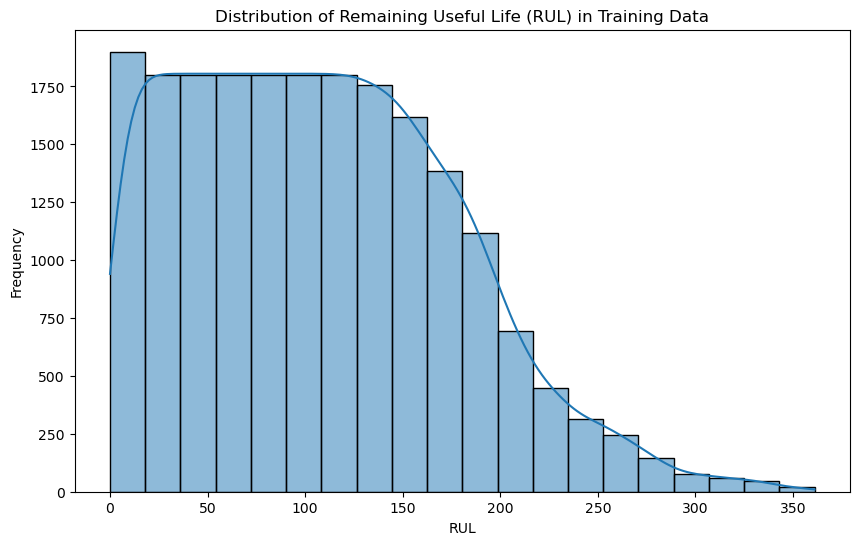

In [54]:
# Visualize the distribution of RUL (remaining useful life) in the training data
plt.figure(figsize=(10, 6))
sns.histplot(train_df['RUL'], bins=20, kde=True)
plt.title('Distribution of Remaining Useful Life (RUL) in Training Data')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.show()


### Correlation heatmap of sensor readings

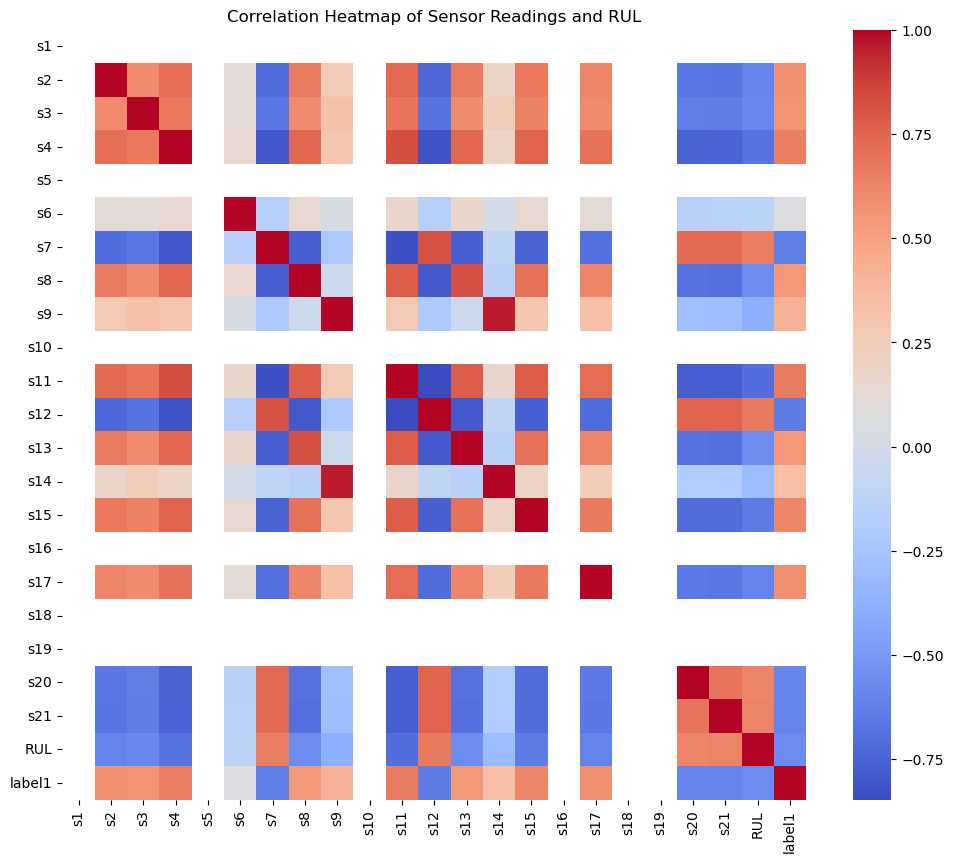

In [60]:
# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define sensor columns
sensor_columns = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
                  's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
                  's20', 's21']

# Concatenate sensor columns with RUL
columns_to_correlate = sensor_columns + ['RUL', 'label1']

# Correlation heatmap of sensor readings and RUL
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[columns_to_correlate].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Sensor Readings and RUL')
plt.show()


#### Interpretation



**1. Reduce Redundancy:** 

negative correlations are represented by cooler colors (e.g., blue), positive correlations by warmer colors (e.g., red), and no correlation by neutral colors (e.g., white). We have the whole spectrum, with a **strong positive correlation between s9 and s14**, which indicates that the two sensors tend to increase or decrease together. We have strong posotive and strong negative correlations between other sensors as well. Sensors s20 and s21 often have negative correlation to the most of other sensors except of s7 and s12.

Positive correlations may indicate redundancy in the data. In such cases, it might be redundant to include both sensors in a predictive model or analysis, as they provide similar information. Reducing redundancy can simplify the model and potentially improve its interpretability without sacrificing predictive performance. 

**We may want to exclude sensor9 or sensor s14 to reduce redundancy.**



**2. Feature Selection:** 
    
Correlation analysis can help in selecting the most informative sensors for predictive modeling or analysis. Sensors with high correlations with the target variable (e.g., RUL) or with other important features may be prioritized for inclusion in the model. Conversely, sensors with low or no correlations with the target variable may be considered for exclusion to simplify the model without sacrificing predictive performance.

- For RUL task (Regression: Predict the Remaining Useful Life (RUL), or Time to Failure (TTF)): **Sensors with no or low negative or positive correlation to RUL: s1, s5, s6, s10, s16, s18, s19. We may want to exclude these sensors from the feature scope for RUL task.**

- For failure prediction (Binary classification: Predict if an asset will fail within certain time frame (e.g. days). **Sensors s1, s5, s6, s10, s16, s18, s19 have no or low negative or positive correlation to label1. These are same sensors as before. This may indicate that information from them has no influence on the failures and RUL.**


## Data Preprocessing

### Normalization (min-max)

Scale numerical features to a specific range (between 0 and 1). This normalization technique subtracts the minimum value from each observation and then divides by the range of the data (i.e., the maximum value minus the minimum value).

In [64]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


### Generate labels for test data (from ground truth dataset)

In [65]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [66]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0,0


### Feature Engineering (skipped for now)

We allow LSTM to select relevant features. Though, my previous analysis with heatmap (see above) gives insights on the importance of the sensors and sensors we could drop to reduce the number of features.

## Modelling


When using LSTMs in the time-series domain, one important parameter to **pick is the sequence length which is the window for LSTMs to look back.** The critical advantage of LSTMs is their ability to remember from these long-term sequences (window sizes) which is hard to achieve by traditional feature engineering. 
 While feature engineering over large window sizes may not make sense, LSTMs are able to use larger window sizes and use all the information in the window as input. 

In [67]:
# pick a large window size of 50 cycles
sequence_length = 50

An example of the sensor values 50 cycles prior to the failure for engine id 3. We will be feeding LSTM network this type of data for each time step for each engine id.

In [69]:
# preparing data for visualizations 

# window of 50 cycles prior to a failure point for engine id 3

engine_id3 = test_df[test_df['id'] == 3]

"""
# create a window of 50 cycles prior to the failure 
point for engine ID 3 by filtering the rows where the 'RUL' (Remaining Useful Life) 
is less than or equal to the minimum 'RUL' value plus 50. 
This ensures that the window includes the last 50 cycles before failure:
"""

engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]  

# Sensor readings are divided into two groups ('cols1' and 'cols2') for better visualization. 

cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]


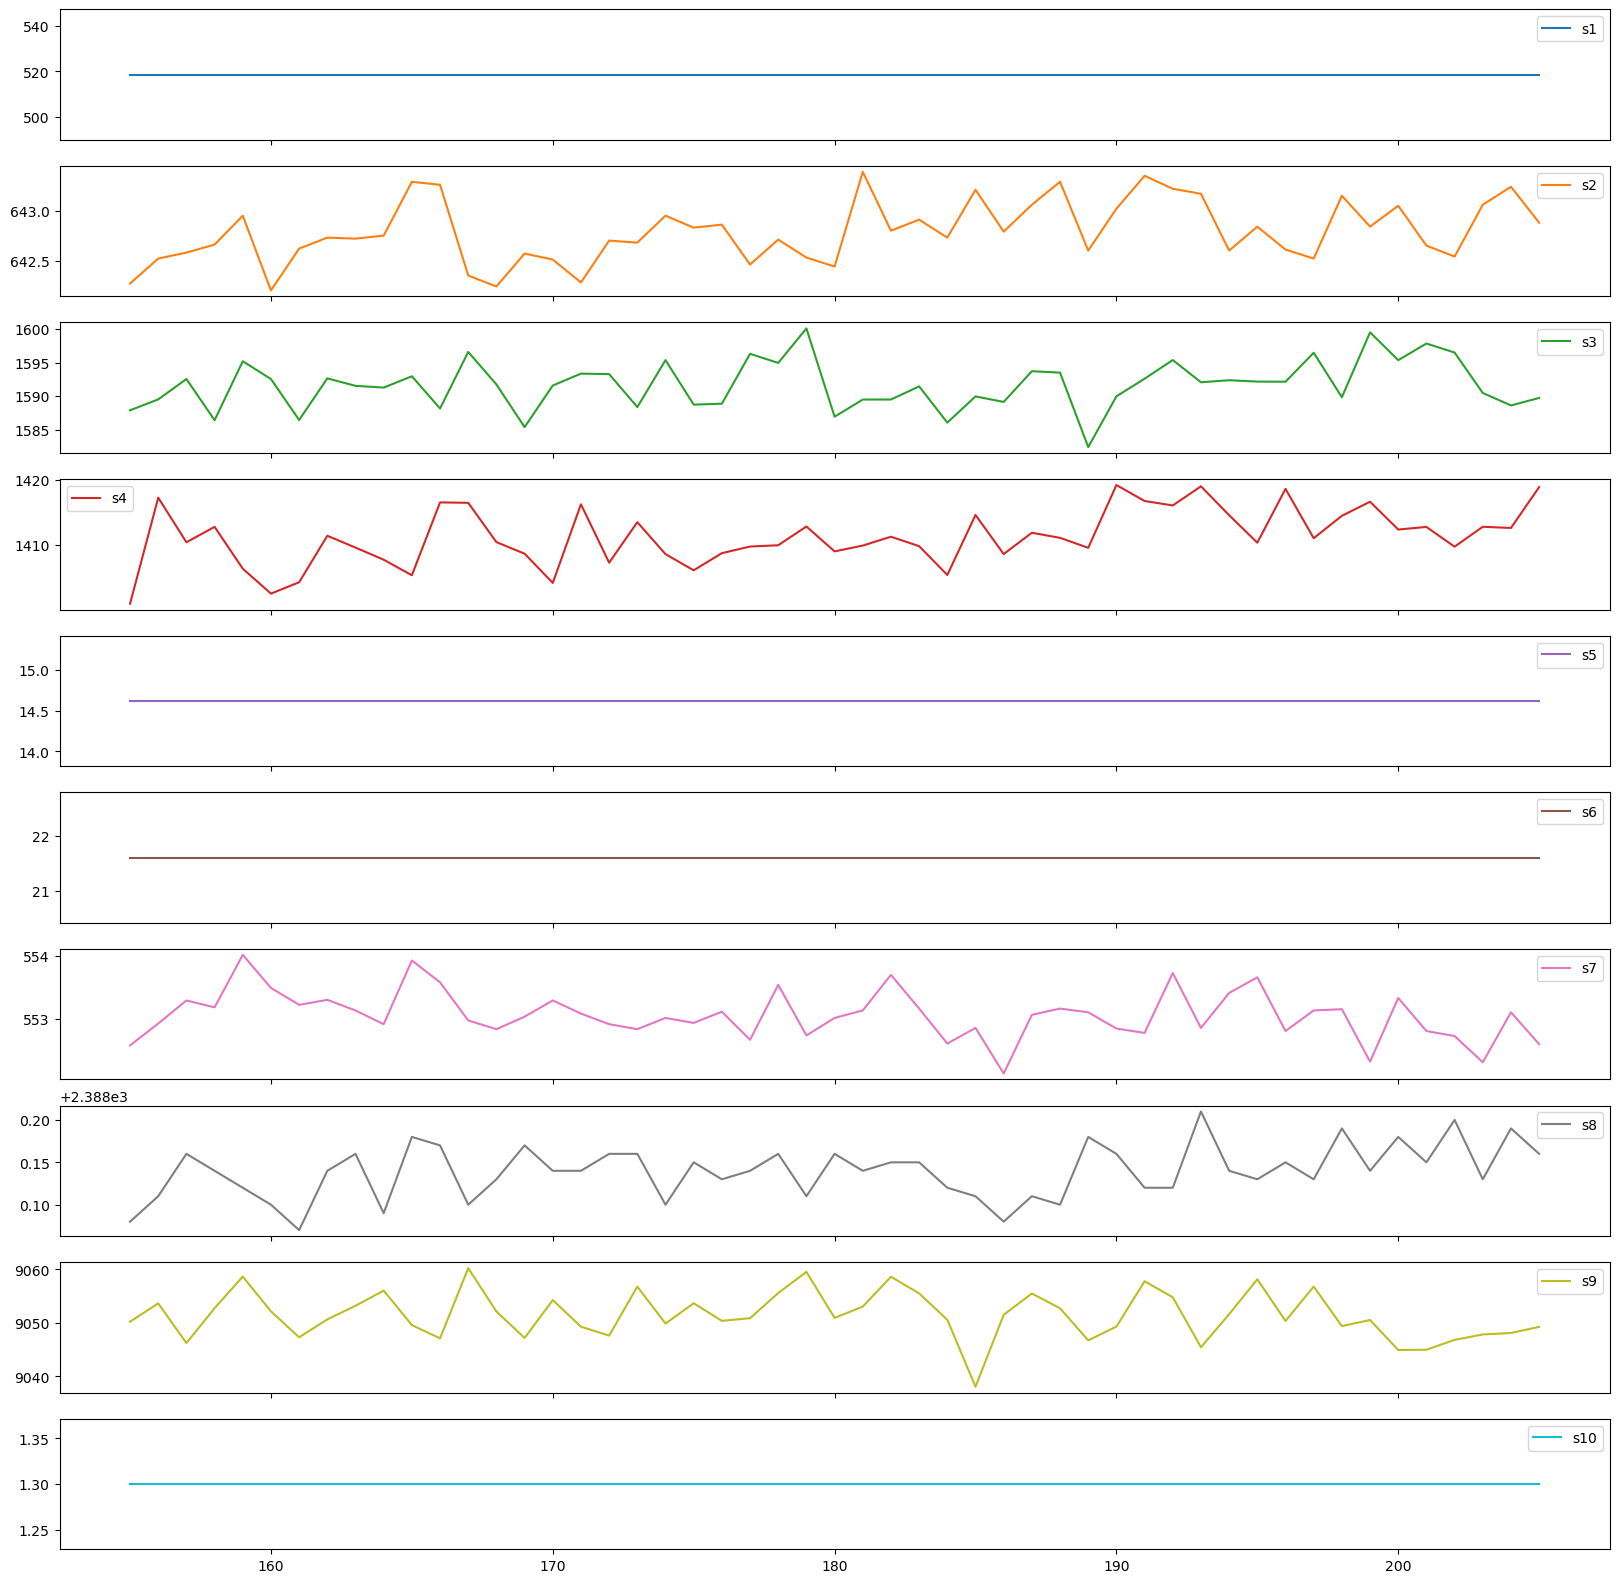

In [70]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

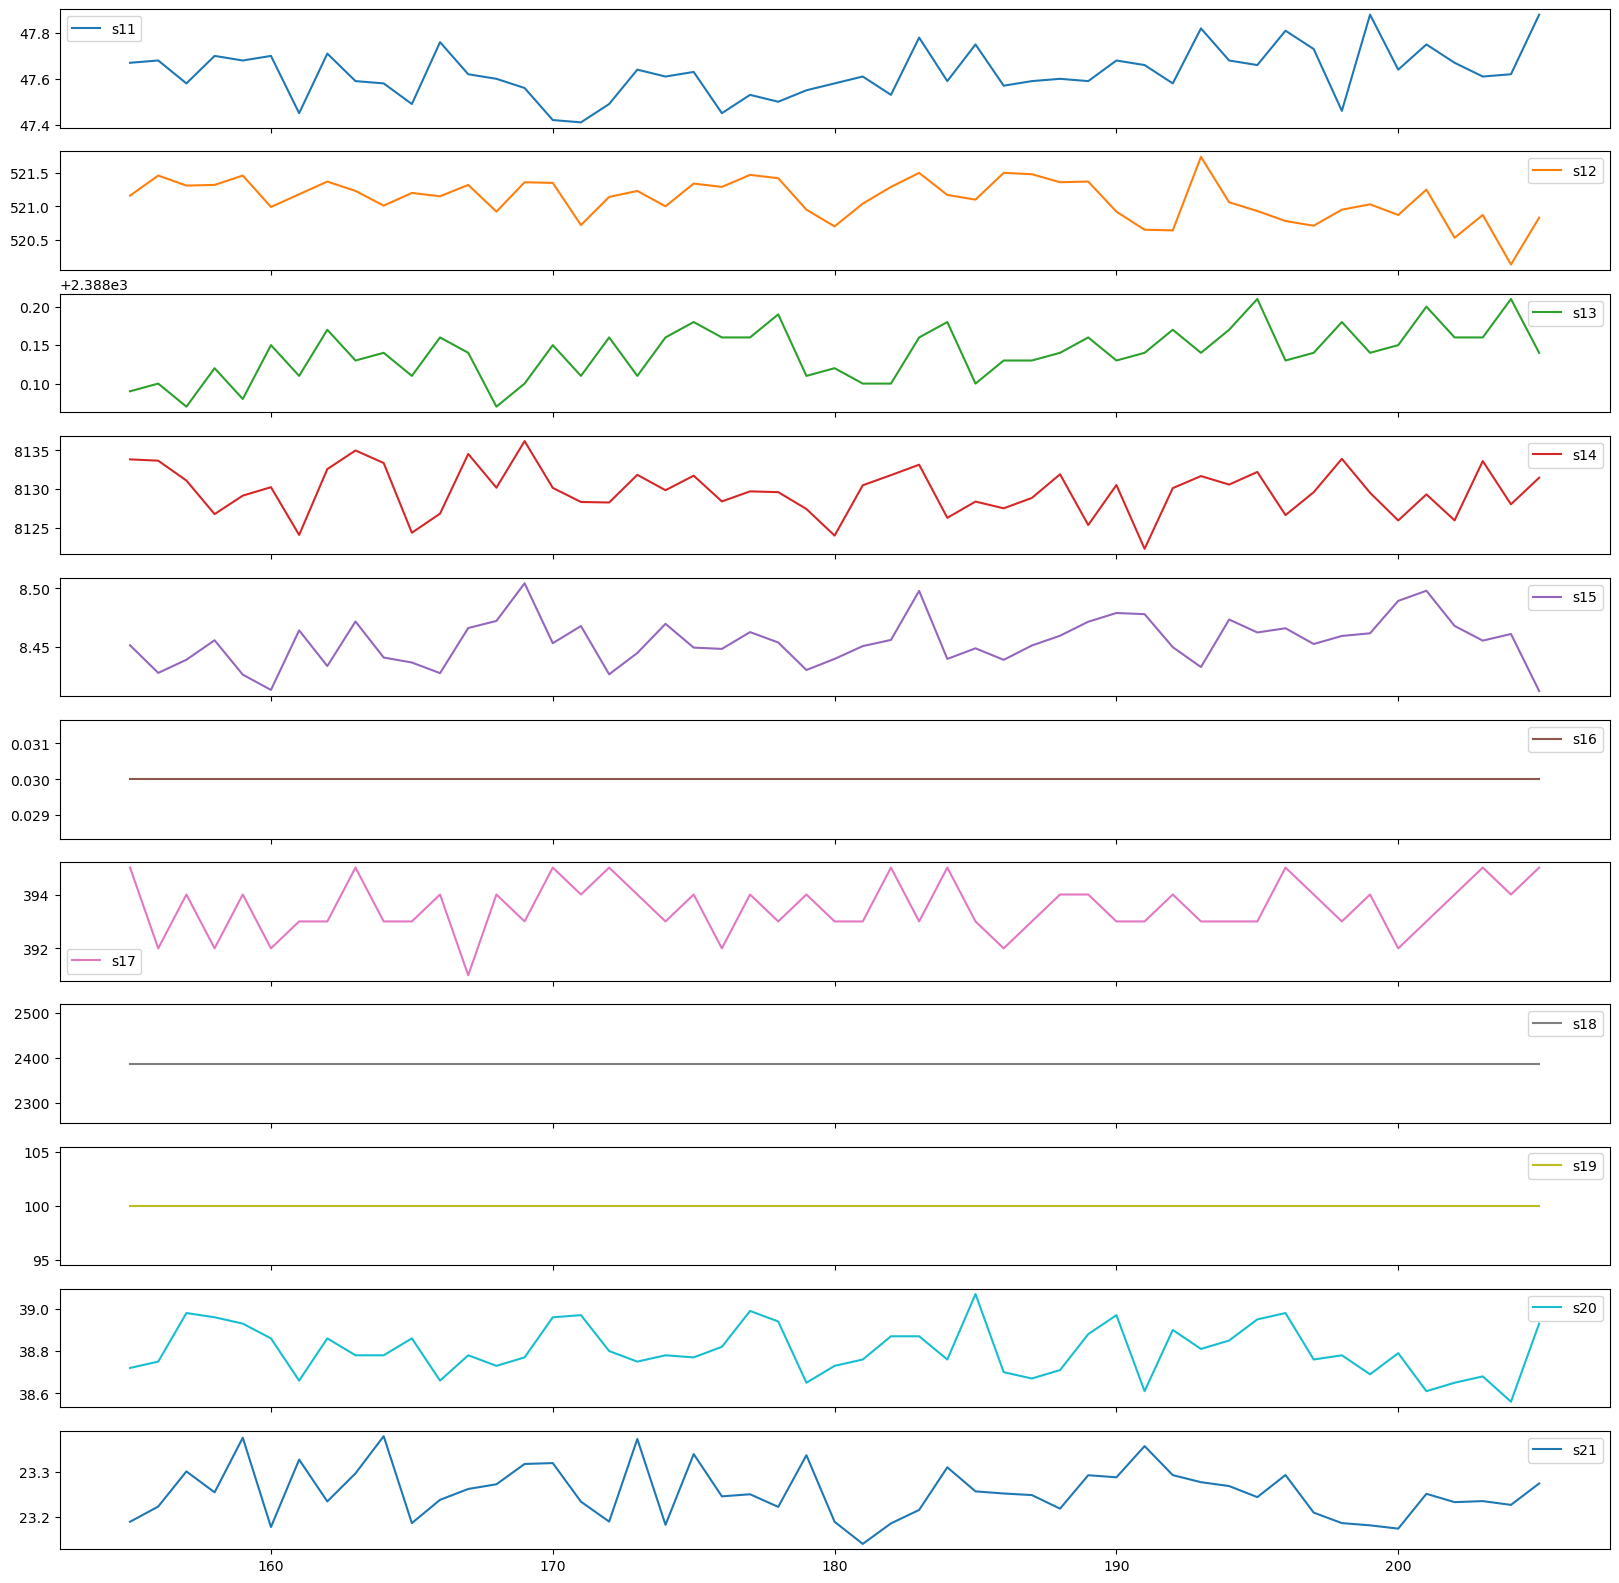

In [71]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

Keras LSTM layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.

**Example for Better Understanding:**

*Sample data array*

```
# Define the sample data array
data = np.array([
    [
        [0.1, 0.2],
        [0.3, 0.4],
        [0.5, 0.6]
    ],
    [
        [0.7, 0.8],
        [0.9, 0.1],
        [0.2, 0.3]
    ],
    [
        [0.4, 0.5],
        [0.6, 0.7],
        [0.8, 0.9]
    ]
])

# Information about the data
# - 3 samples (training sequences)
# - Each sample has 3 time steps
# - Each time step contains 2 features
```

In [72]:
# function to reshape features into (samples, time steps, features) 

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [73]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [74]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [75]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

## TASK 1: Binary classification: Predict if an asset will fail within certain time frame

Comment: 15 631 samples, 50 time steps (lookup window before failure), 25 features

### Generate an array with label1 labels:

In [76]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [77]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

Comment: 15 631 labels for the same amount of samples, one-class.

## LSTM Network for binary classification: Predict if an asset will fail within certain time frame

In [ ]:

## TASK 1: Regression: Predict the Remaining Useful Life (RUL), or Time to Failure (TTF).

# References

- https://github.com/anshulofficial/Predictive-Maintenance-using-LSTM?tab=readme-ov-file
- https://www.nasa.gov/intelligent-systems-division/#turbofan
- https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
- https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2
- https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3
